In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 67.7MB/s]


In [ ]:
df = pd.read_csv("london_bike_sharing.csv",parse_dates=['timestamp'],index_col="timestamp")

In [ ]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
df['hour']=df.index.hour
df['day_of_month']=df.index.day
df['day_of_week']=df.index.dayofweek
df['month']=df.index.month

In [ ]:
df

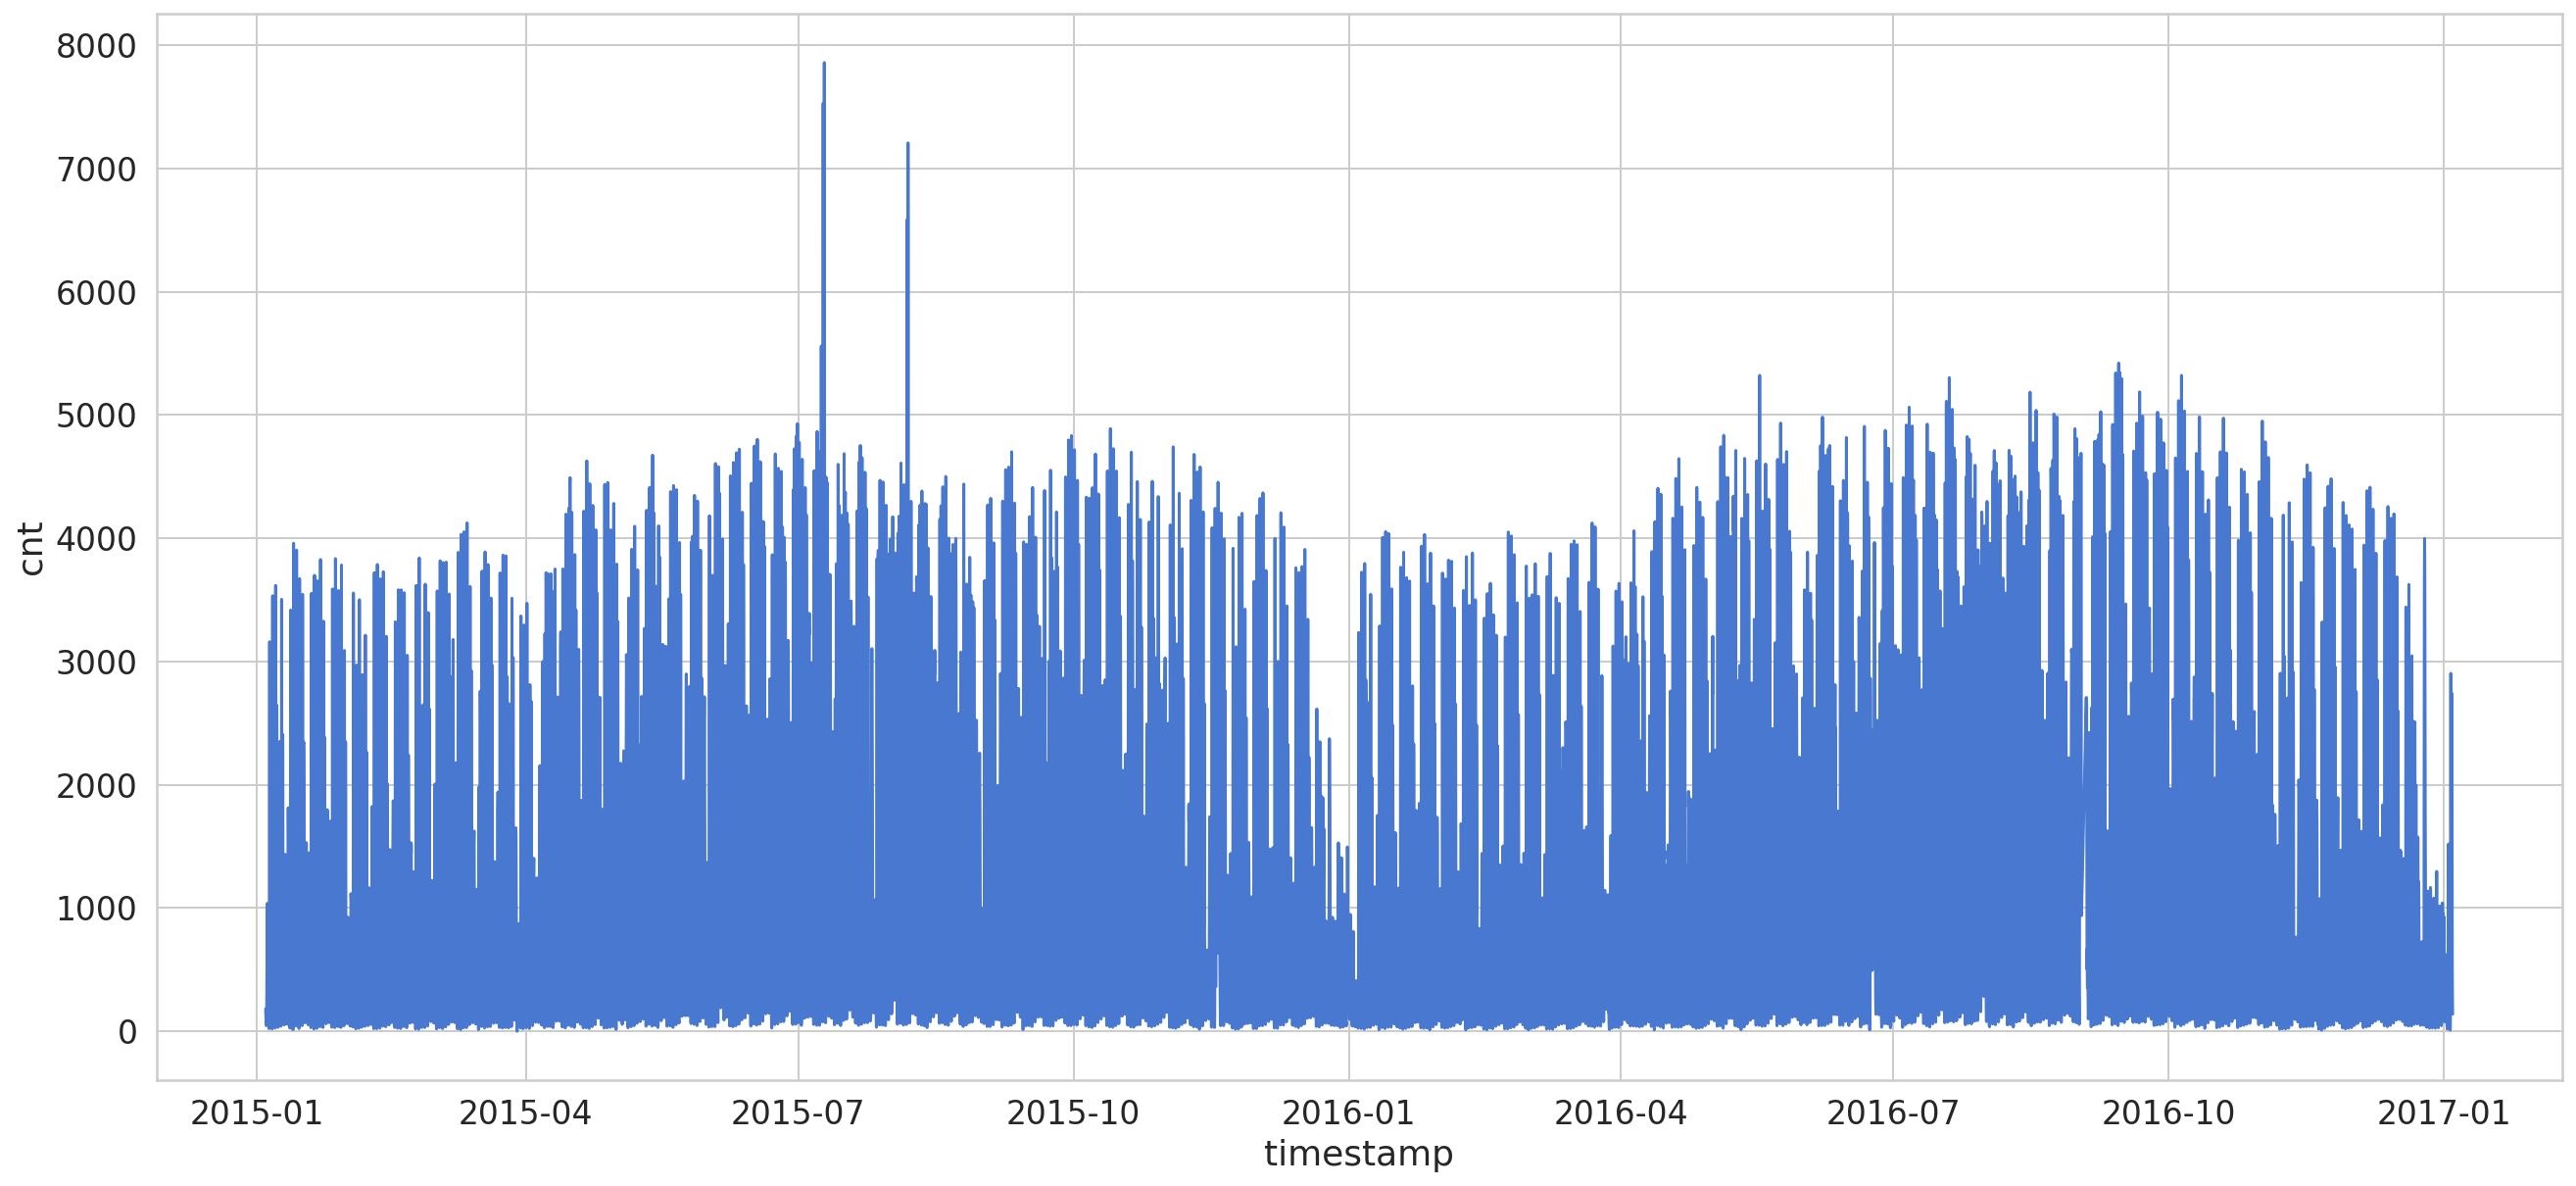

In [ ]:
sns.lineplot(x=df.index, y="cnt", data=df);

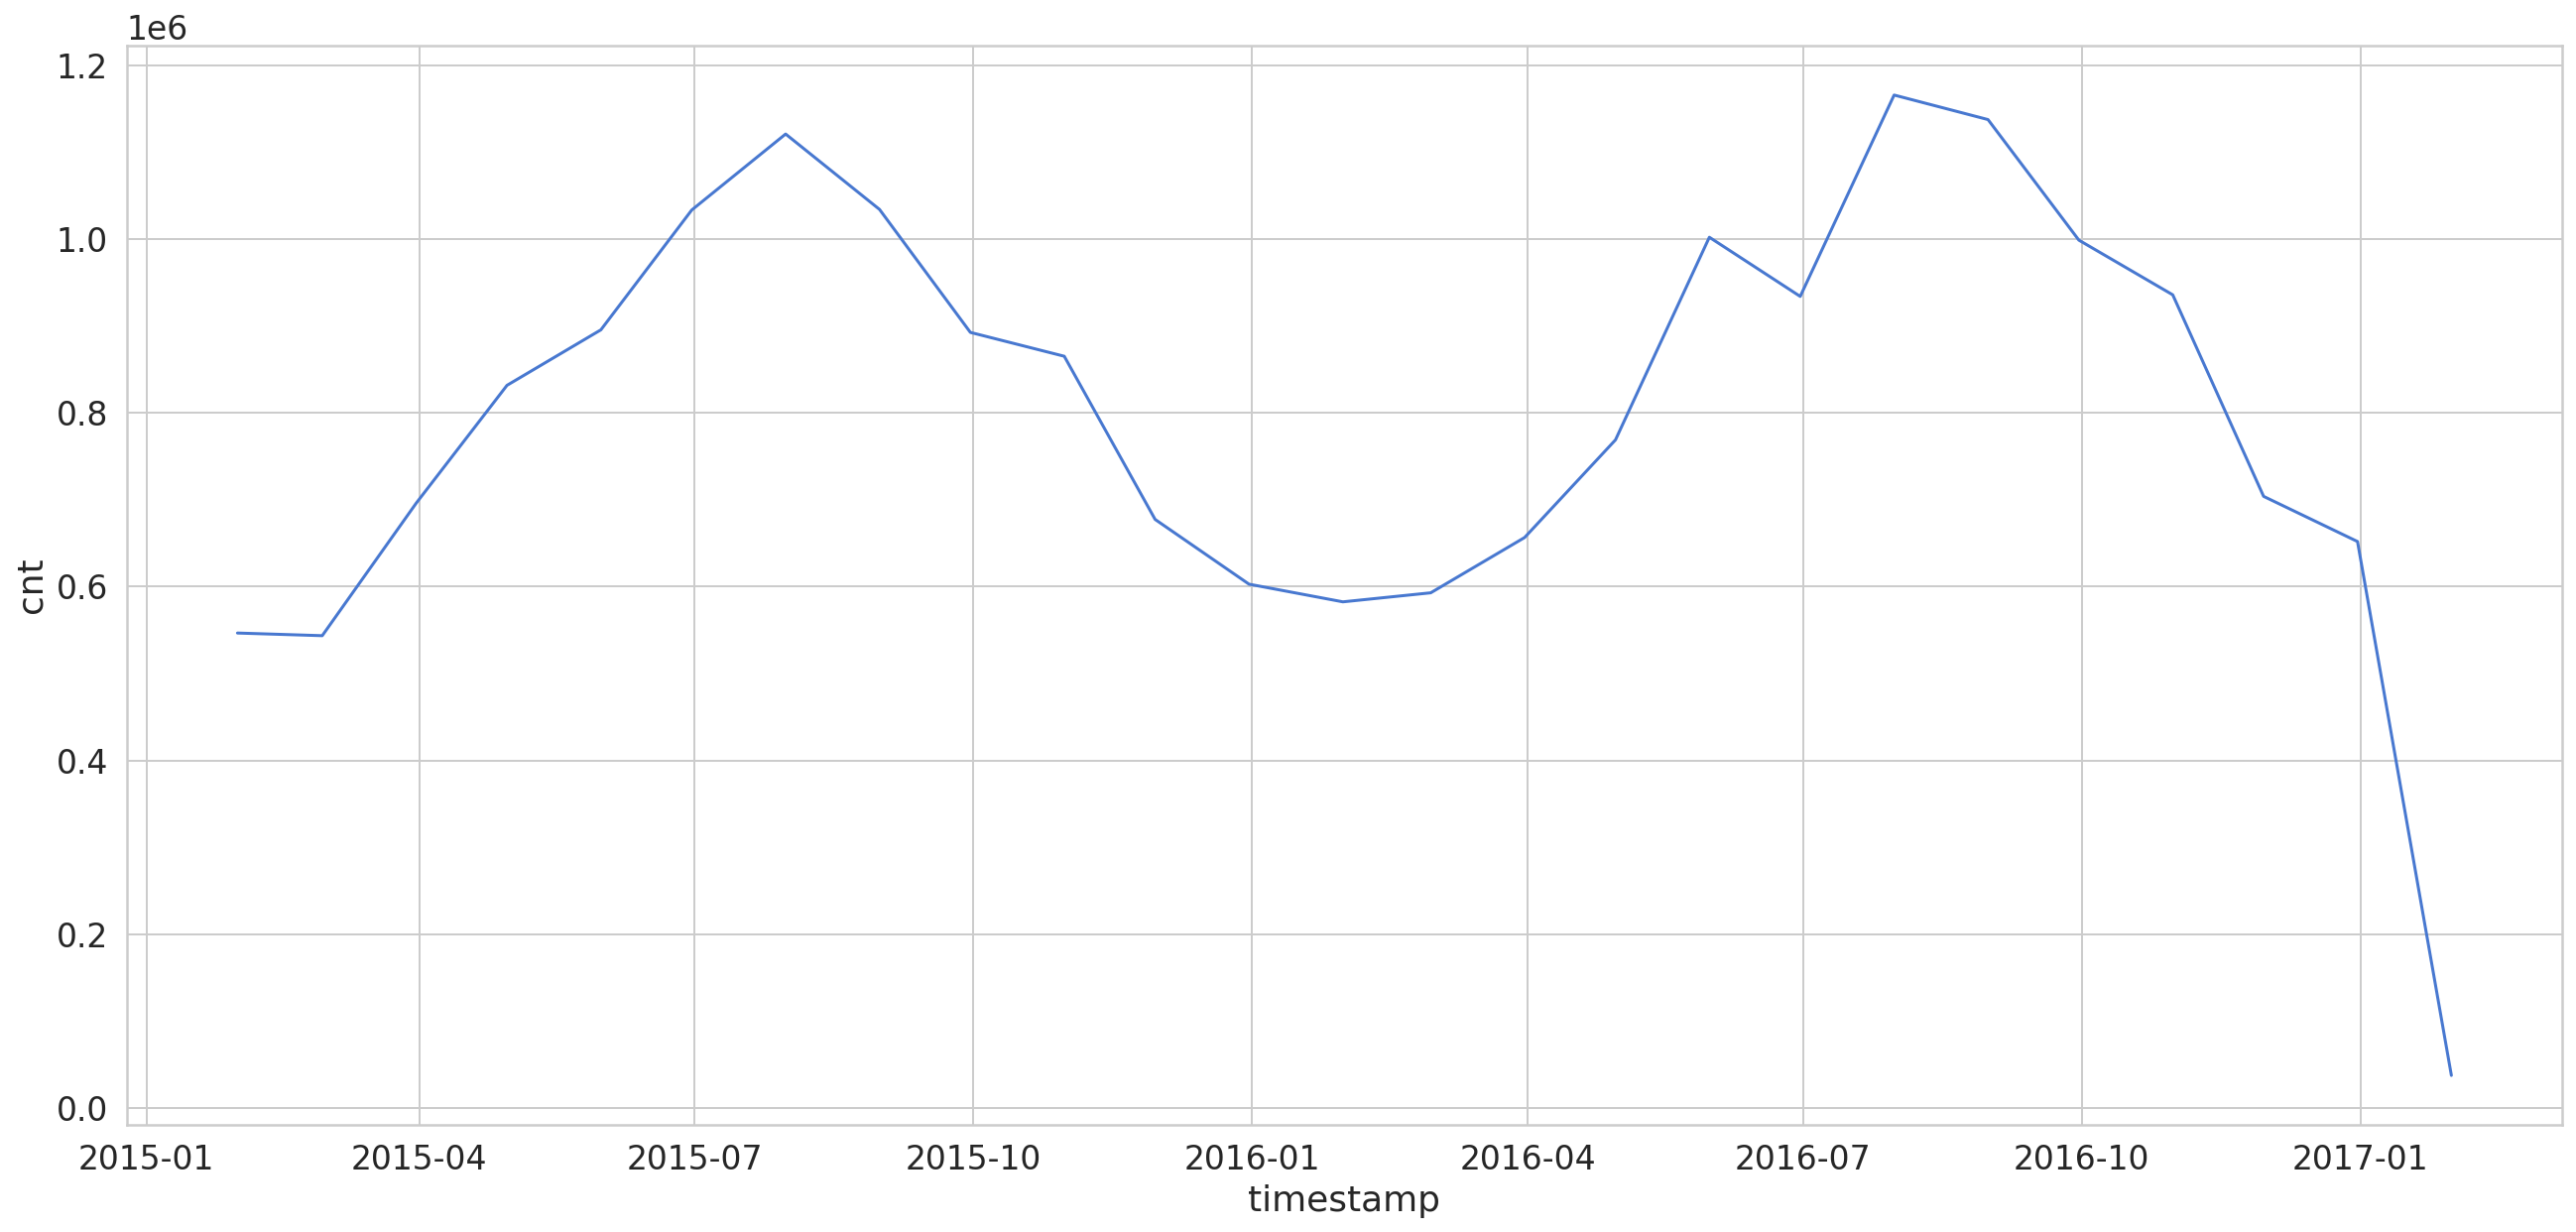

In [ ]:
df_by_month=df.resample('M').sum()
sns.lineplot(x=df_by_month.index,y="cnt",data=df_by_month);

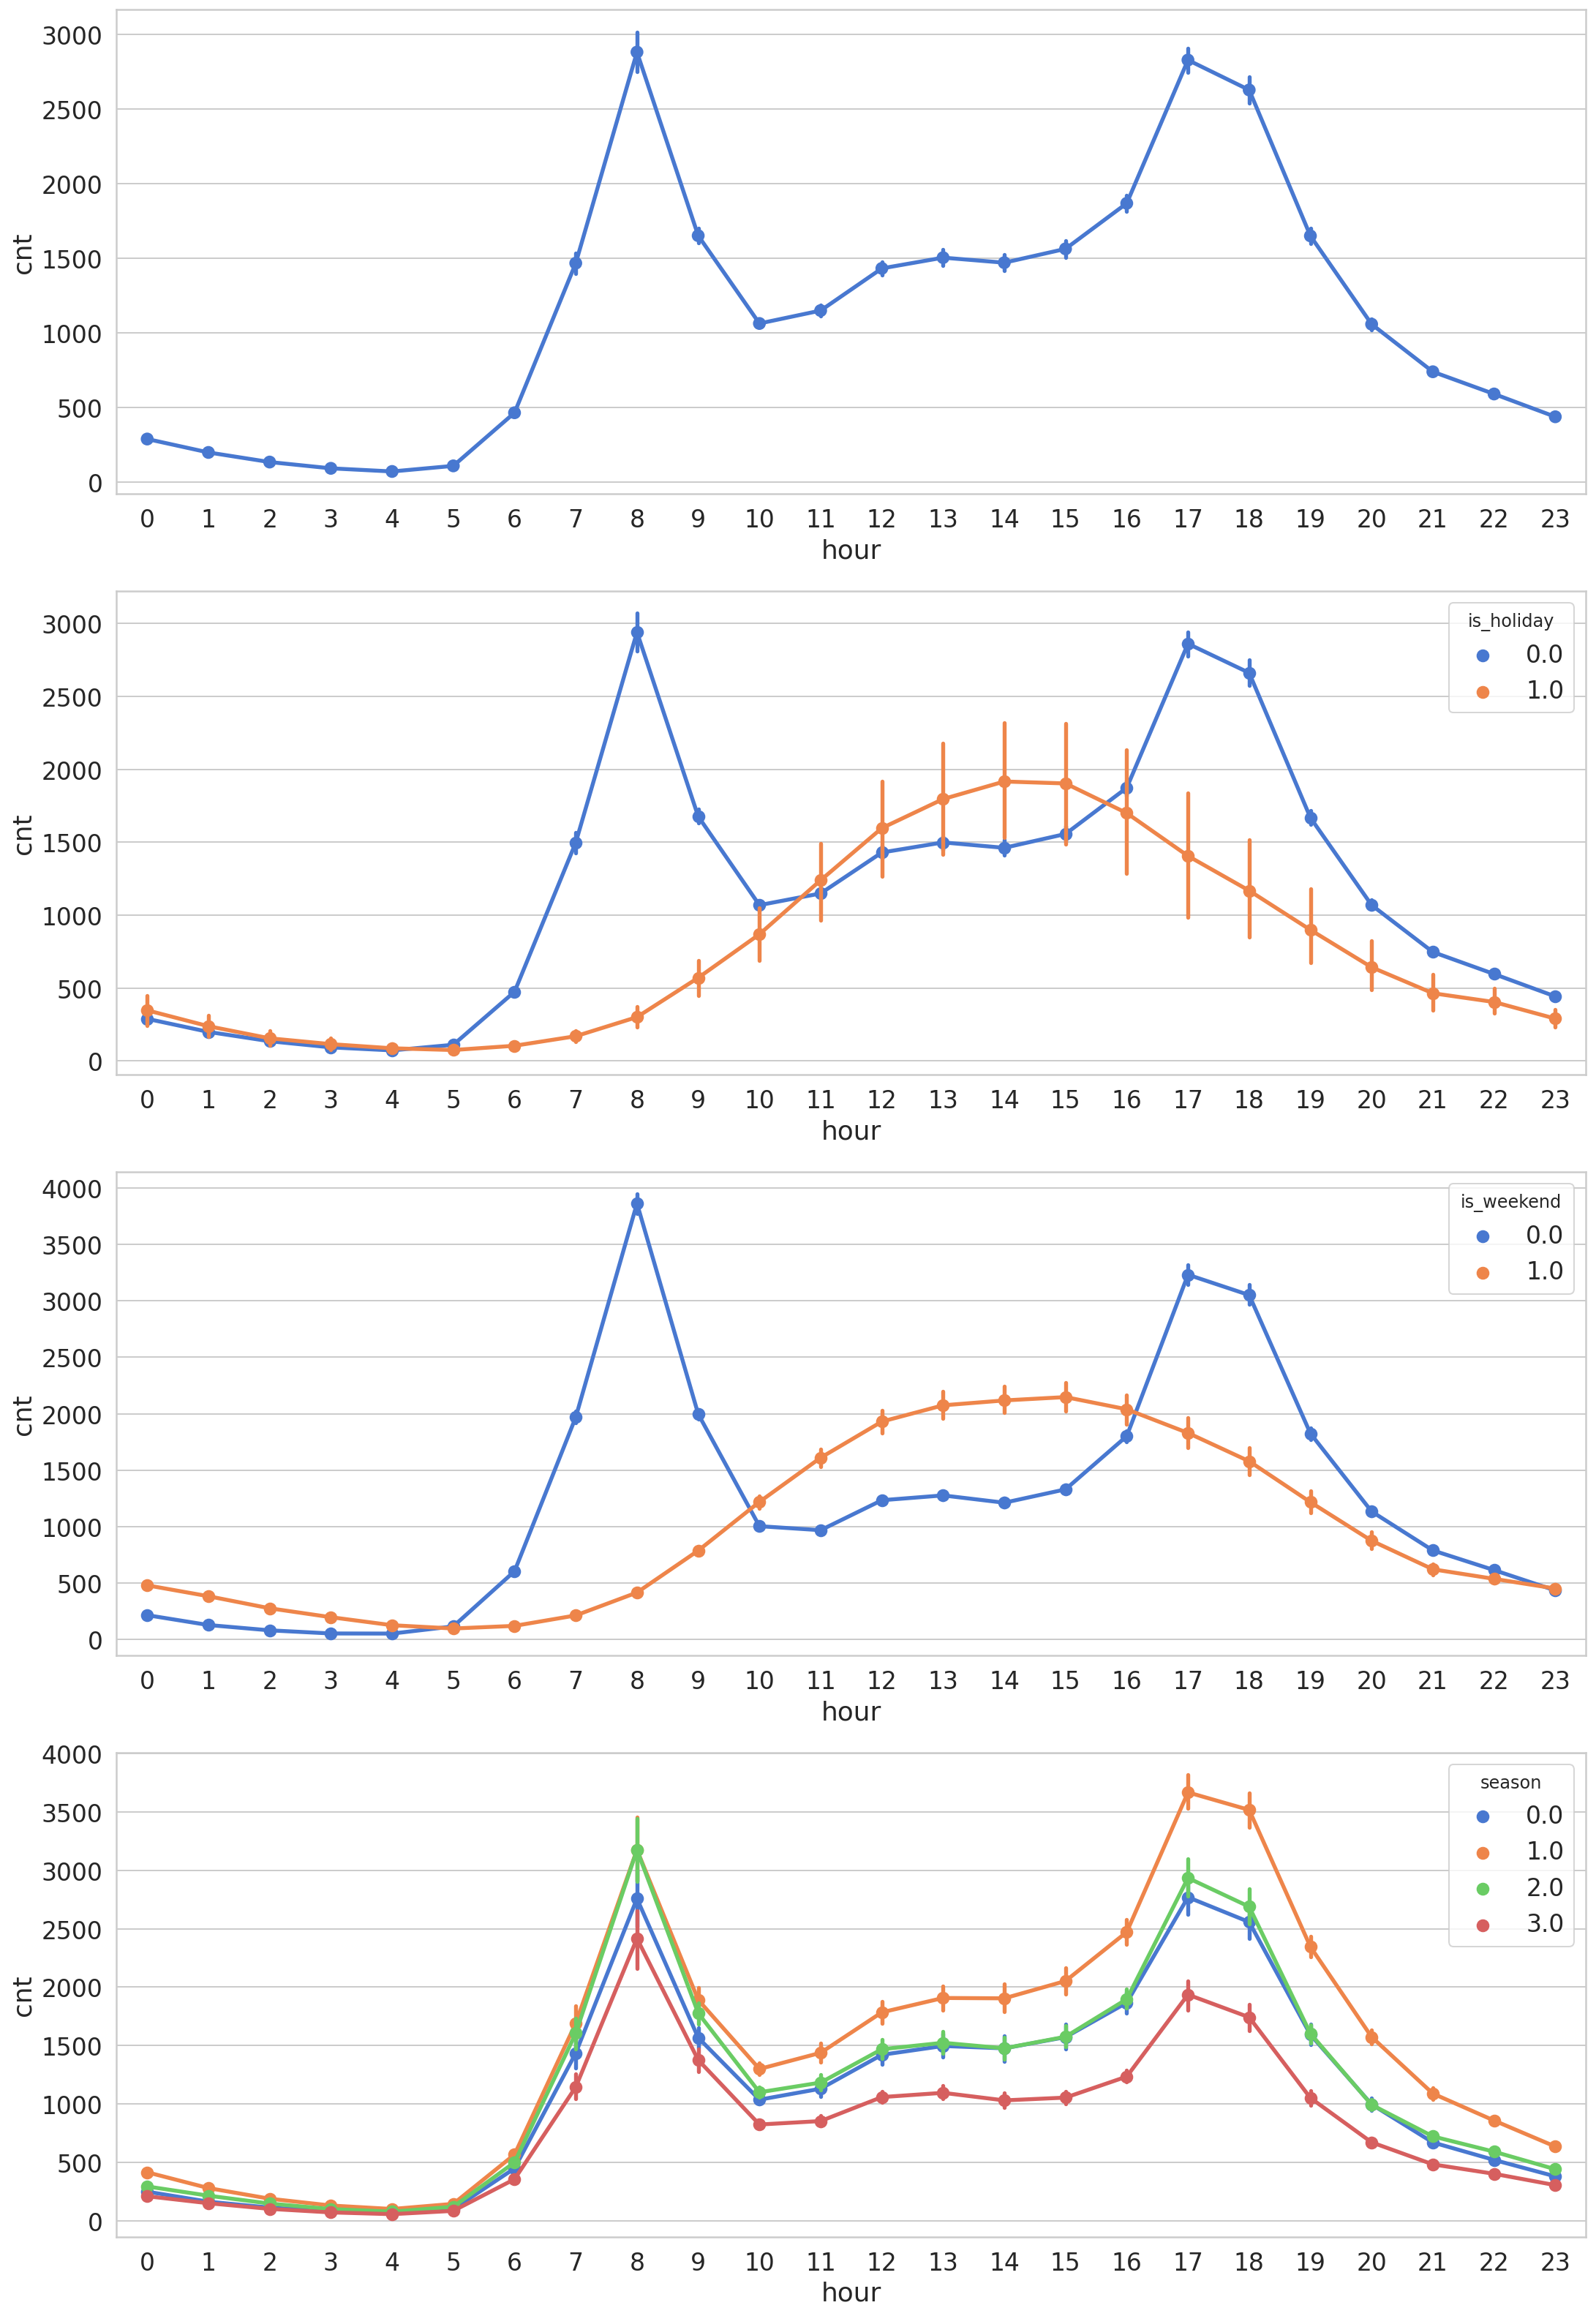

In [ ]:

fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

In [ ]:
train_size=int(len(df)*0.9)
test_size=len(df)-train_size
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(len(train),len(test))

15672 1742


In [ ]:
train

In [ ]:
from sklearn.preprocessing import RobustScaler


In [ ]:

from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [ ]:
train

In [ ]:
test

In [ ]:
def create_dataset(X,y,time_steps=1):
  Xs,ys=[],[]
  for i in range(len(X)-time_steps):
    v=X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [ ]:
time_steps=10
X_train,y_train=create_dataset(train,train.cnt,time_steps)
X_test,y_test=create_dataset(test,test.cnt,time_steps)


In [ ]:
print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [ ]:

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 3s 6ms/step - loss: 0.3341 - val_loss: 0.1349
Epoch 2/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0856 - val_loss: 0.0570
Epoch 3/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0504 - val_loss: 0.0473
Epoch 4/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0411 - val_loss: 0.0398
Epoch 5/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0346 - val_loss: 0.0329
Epoch 6/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0298 - val_loss: 0.0332
Epoch 7/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0264 - val_loss: 0.0352
Epoch 8/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0249 - val_loss: 0.0319
Epoch 9/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0241 - val_loss: 0.0324
Epoch 10/30
441/441 [==============================] - 2s 5ms/step - loss: 0.0220 - val_loss: 0.0383